# Markov Chain Monte Carlo




## Setup

We'll use some utilities from Pyro, a probabilistic programming language that wraps PyTorch. Pyro requires PyTorch 1.11 so this `pip install` command will take a little time.

In [1]:
!pip install -q pyro-ppl 

## Bayesian inference with MCMC in the hierarchical Gaussian model

Let's return to the "8 Schools" example from Lecture 3. To recap: we have test scores from $S$ schools. Let $N_s$ denote the number of students from school $s$ and $x_{s,n} \in \mathbb{R}$ denote the score of the $n$-th student from the $s$-th school. 

We model the collection of scores using a **hierarchical model**. Unlike last time, now we will add a prior on the per-school variance as well.

$$
\begin{align*}
    \tau^2 &\sim \chi^{-2}(\nu_0, \tau_0^2) \\
    \mu &\sim \mathcal{N}(\mu_0, \tau^2 / \kappa_0) \\
    \theta_s &\sim \mathcal{N}(\mu, \tau^2) & \text{for } s&=1,\ldots,S \\
    \sigma_s^2 &\sim \chi^{-2}(\alpha_0, \sigma_0^2) & \text{for } s&=1,\ldots,S \\
    x_{s,n} &\sim \mathcal{N}(\theta_s, \sigma_s^2) & \text{for } n&=1,\ldots,N_s \text{ and } s=1,\ldots,S
\end{align*}
$$

Each school has its own mean $\theta_s$ and variance $\sigma_s^2$. The means are linked via a hierarchical prior: they are conditionally independent given the global mean $\mu$ and variance $\tau^2$

We will use MCMC to draw approximate samples from the posterior distribution $p(\tau^2, \mu, \{\theta_s, \sigma_s^2\}_{s=1}^S \mid \{\{x_{s,n}\}_{n=1}^{N_s}\}_{s=1}^S, \eta)$.

In [2]:
# Setup
import torch
from torch.distributions import Normal, Gamma, Categorical, \
    TransformedDistribution
from torch.distributions.transforms import PowerTransform

from pyro.ops.stats import effective_sample_size, autocorrelation

from fastprogress import progress_bar
import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("notebook")

In [3]:
class ScaledInvChiSq(TransformedDistribution):
    """
    Implementation of the scaled inverse \chi^2 distribution defined in class.
    We will implement it as a transformation of a gamma distribution.
    """
    def __init__(self, dof, scale):
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

## Sample synthetic data

We will modify the data from the 8 shcools example of Gelman et al (2013). Specifically, we'll sample 20 scores so that they have the same mean and the specified standard deviation. 

Remember that $\bar{\sigma}_s = \sigma_s / \sqrt{N_s}$ in our notation from Lecture 3.

In [4]:
# Hyper parameters
S = 8                   # number of schools
N_s = torch.tensor(20)  # number of students per school
mu_0 = 0.0              # prior mean of the global effect
kappa_0 = 0.1           # prior concentration in the NIX prior
nu_0 = 0.1              # degrees of freedom for the prior on \tau^2
tausq_0 = 100.0         # prior mean of the variance \tau^2
alpha_0 = 0.1           # degrees of freedom for the prior on \sigma_s^2
sigmasq_0 = 10.0        # scale of the prior on \sigma_s^2

# Sample data
torch.manual_seed(305)
x_bars = torch.tensor([28., 8., -3., 7., -1., 1., 18., 12.])  
sigma_bars = torch.tensor([15., 10., 16., 11., 9., 11., 10., 18.])
xs = Normal(x_bars, torch.sqrt(N_s) * sigma_bars).sample((N_s,))    

# z-score the samples
zs = (xs - xs.mean(axis=0)) / xs.std(axis=0)

# Rescale so they have the desired variance
xs = x_bars + torch.sqrt(N_s) * sigma_bars * zs

# Note: xs.shape == (N_s, S)
assert torch.allclose(xs.mean(axis=0), x_bars)
assert torch.allclose(xs.std(axis=0), torch.sqrt(N_s) * sigma_bars)

## Gibbs Sampling

We will use Gibbs sampling to draw approximate samples from the posterior distribution. The idea is to cycle between each latent variable and sample from its conditional distribution given the current settings of the remaining variables. In models like this one, the conditional distributions often have simple closed forms. We will derive and implement the updates one at a time.

## Calculate the log joint probability

First, we will write a function to compute the log joint probability.
This will be useful for tracking the Gibbs sampler's progress over iterations. 

In [5]:
def log_probability(tausq, mu, thetas, sigmasqs, xs,
                    tausq_0, nu_0, mu_0, kappa_0, alpha_0, sigmasq_0):
    """
    Compute the log joint probability of the model parameters and data given the 
    hyperparameters of the model. 

    Args:

    tausq:      a scalar \tau^2 value
    mu:         a scalar mu value
    thetas:     a shape (S,) tensor of \theta values
    sigmasqs:   a shape (S,) tensor of \sigma_s^2 values
    xs:         a shape (S, N_s) tensor of data points
    tausq_0:    scale of prior on \tau^2
    nu_0:       degrees of freedom of prior on \tau^2
    mu_0:       mean of prior on \mu
    kappa_0:    precision of prior on \mu
    alpha_0:    degrees of freedom of prior on \sigma_s^2
    sigmasq_0:  scale of prior on \sigma_s^2
    
    Returns:

    Log joint probability.
    """
    lp = ScaledInvChiSq(nu_0, tausq_0).log_prob(tausq)
    lp += Normal(mu_0, torch.sqrt(tausq / kappa_0)).log_prob(mu)
    lp += Normal(mu, torch.sqrt(tausq)).log_prob(thetas).sum()
    lp += ScaledInvChiSq(alpha_0, sigmasq_0).log_prob(sigmasqs).sum()
    lp += Normal(thetas, torch.sqrt(sigmasqs)).log_prob(xs).sum()
    return lp

## Gibbs update for $\theta_s$

We have

$$
\begin{align*}
    p(\theta_s \mid \mu, \tau^2, \sigma_s^2, \mathbf{X}, \boldsymbol{\eta})
    &\propto \mathcal{N}(\theta_s \mid \mu, \tau^2) \prod_{n=1}^{N_s} \mathcal{N}(x_{s,n} \mid \theta_s, \sigma_s^2) \\
    &\propto \prod_{s=1}^S \mathcal{N}(\theta_s \mid \hat{\theta}_s, v_s)
\end{align*}
$$

where

$$
\begin{align*}
    v_s &= \left(\frac{N_s}{\sigma_s^2} + \frac{1}{\tau^2} \right)^{-1} &
    \hat{\theta}_s &= v_s \left(\sum_{n=1}^{N_s}\frac{x_{s,n}}{\sigma_s^2} + \frac{\mu}{\tau^2} \right)
\end{align*}
$$

I.e. the conditional means are precision-weighted averages of the prior and sample means.

**Note:** all of the $\theta_s$ parameters are conditionally independent given the remaining variables. That means we can sample them all in parallel using a **blocked Gibbs update**.

In [6]:
def gibbs_sample_thetas(tausq, mu, sigmasqs, xs):
    """
    Sample the conditional distribution of \theta_s given all the other 
    variables. Since the \theta_s parameters are conditionally independent given 
    everything else, we can sample them in parallel as a blocked Gibbs step. 

    Args:

    tausq:      a scalar \tau^2 value
    mu:         a scala mu value
    sigmasqs:   a shape (S,) tensor of \sigma_s^2 values
    xs:         a shape (S, N_s) tensor of data points

    Returns:

    A shape (S,) tensor of \theta_s values drawn from their complete conditional
    """
    N_s = xs.shape[0]
    v_theta = 1 / ((N_s / sigmasqs) + (1 / tausq))
    theta_hat = v_theta * ((xs.sum(axis=0) / sigmasqs) + mu / tausq)
    thetas = Normal(theta_hat, torch.sqrt(v_theta)).sample()
    return thetas

## Gibbs update for $\sigma_s^2$

The conditional distribution of $\sigma_s^2$ given all the other variables is,

$$
\begin{align*}
p(\sigma_s^2 \mid \theta_s, \{x_{s,n}\}_{n=1}^{N_s}, \alpha_0, \sigma_0^2) &\propto 
\chi^{-2}(\sigma_s^2 \mid \alpha_0, \sigma_0^2) \prod_{n=1}^{N_s} \mathcal{N}(x_{s,n} \mid \theta_s, \sigma_s^2) \\
&\propto \chi^{-2}(\sigma_s^2 \mid \alpha_N, \sigma_N^2) 
\end{align*}
$$

where

$$
\begin{align*}
\alpha_N &= \alpha_0 + N_s \\
\sigma_N^2 &= \frac{1}{\alpha_N} \left(\alpha_0 \sigma_0^2 + \sum_{n=1}^{N_s} (x_{s,n} - \theta_s)^2 \right) 
\end{align*}
$$

**Note:** Recall Lecture 1 on a normal model with unknown variance. Same thing here.

In [7]:
def gibbs_sample_sigmasq(alpha_0, sigmasq_0, thetas, xs):
    """
    Sample the conditional distribution of \sigma_s^2 given all the other 
    variables. Since the \sigma_s^2 parameters are conditionally independent 
    given everything else, we can sample them in parallel as a blocked Gibbs 
    step. 

    Args:

    alpha_0:    degrees of freedom of prior on \sigma_s^2
    sigmasq_0:  scale of prior on \sigma_s^2
    thetas:     a shape (S,) tensor of \theta_s values
    xs:         a shape (S, N_s) tensor of data points

    Returns:

    A shape (S,) tensor of \sigma_s^2 values drawn from their complete 
    conditional distribution.
    """
    N_s = xs.shape[0]
    alpha_N = alpha_0 + N_s
    sigmasq_N = 1 / alpha_N * (alpha_0 * sigmasq_0 
                               + torch.sum((xs - thetas)**2, axis=0))
    return ScaledInvChiSq(alpha_N, sigmasq_N).sample()

## Gibbs update for $\mu$

The conditional distribution of $\mu$ given everything else is,

$$
\begin{align*}
p(\mu \mid \{\theta_s\}_{s=1}^S, \tau^2, \mu_0, \kappa_0) 
&\propto \mathcal{N}(\mu \mid \mu_0, \tau^2 / \kappa_0) \prod_{s=1}^S \mathcal{N}(\theta_s \mid \mu, \tau^2) \\
&\propto \mathcal{N}(\mu \mid \hat{\mu}, v_\mu) 
\end{align*}
$$

where

$$
\begin{align*}
v_\mu &= \frac{1}{\frac{\kappa_0}{\tau^2} + \frac{S}{\tau^2}} = \frac{\tau^2}{\kappa_0 + S} \\
\hat{\mu} &= v_\mu \left( \frac{\mu_0 \kappa_0}{\tau^2} + \sum_{s=1}^S \frac{\theta_s}{\tau^2} \right) = \frac{\mu_0 \kappa_0 + \sum_{s=1}^S \theta_s }{\kappa_0 + S}
\end{align*}
$$

In [8]:
def gibbs_sample_mu(mu_0, kappa_0, tausq, thetas):
    """
    Sample the conditional distribution of \mu given all the other 
    variables. 

    Args:

    mu_0:       mean of prior on \mu
    kappa_0:    precision of prior on \mu
    tausq:      sample of the global variance, \tau^2
    thetas:     a shape (S,) tensor of \theta_s values

    Returns:

    Scalar sample of \mu from its complete conditional distribution.
    """
    S = len(thetas)
    v_mu = tausq / (kappa_0 + S)
    mu_hat = (mu_0 * kappa_0 + thetas.sum()) / (kappa_0 + S)
    return Normal(mu_hat, torch.sqrt(v_mu)).sample()

## Gibbs update for $\tau^2$

The conditional distribution of $\tau^2$ given everything else is,

$$
\begin{align*}
p(\tau^2 \mid \mu, \{\theta_s\}_{s=1}^S, \nu_0, \tau_0^2) 
&\propto \chi^{-2}(\tau^2 \mid \nu_0, \tau_0^2) \mathcal{N}(\mu \mid \mu_0, \tau^2 / \kappa_0) \prod_{s=1}^S \mathcal{N}(\theta_s \mid \mu, \tau^2) \\
&\propto \chi^{-2}(\tau^2 \mid \nu_N, \tau_N^2) 
\end{align*}
$$

where

$$
\begin{align*}
\nu_N &= \nu_0 + S + 1 \\
\tau_N^2 &= \frac{1}{\nu_N} \left( \nu_0 \tau_0^2 + \kappa_0 (\mu - \mu_0)^2 + \sum_{s=1}^S (\theta_s - \mu)^2 \right)
\end{align*}
$$

In [9]:
def gibbs_sample_tausq(nu_0, tausq_0, mu_0, kappa_0, mu, thetas):
    """
    Sample the conditional distribution of \mu given all the other 
    variables. 

    Args:

    nu_0:       degrees of freedom of prior on \tau^2
    tausq_0:    scale of prior on \tau^2
    mu_0:       mean of prior on \mu
    kappa_0:    precision of prior on \mu
    mu:         sample of the global mean, \mu
    thetas:     a shape (S,) tensor of \theta_s values

    Returns:

    Scalar sample of \tau^2 from its complete conditional distribution.
    """
    S = len(thetas)
    nu_N = nu_0 + S + 1 
    tausq_N = 1/nu_N * (nu_0 * tausq_0 + kappa_0 * (mu - mu_0)**2 
                        + torch.sum((thetas - mu)**2))
    return ScaledInvChiSq(nu_N, tausq_N).sample()

## Put it all together

That's all the updates! All that is left is a simple function to cycle through these updates one at a time. After each iteration, we will compute and save the log joint probability.

In [10]:
def gibbs(xs, tausq_0, nu_0, mu_0, kappa_0, alpha_0, sigmasq_0, N_samples=1000):
    """
    Run the Gibbs sampler.

    Args:

    xs:         a shape (S, N_s) tensor of data points
    tausq_0:    scale of prior on \tau^2
    nu_0:       degrees of freedom of prior on \tau^2
    mu_0:       mean of prior on \mu
    kappa_0:    precision of prior on \mu
    alpha_0:    degrees of freedom of prior on \sigma_s^2
    sigmasq_0:  scale of prior on \sigma_s^2
    N_samples:  number of Gibbs iterations to run
    
    Returns:

    Dictionary with samples of the parameters tausq, mu, thetas, sigmasqs, and 
    the log joint probability at each iteration.
    """
    N_s, S = xs.shape

    # Initialize the Gibbs sampler with a draw from the prior
    tausq = ScaledInvChiSq(nu_0, tausq_0).sample()
    mu = Normal(mu_0, torch.sqrt(tausq / kappa_0)).sample()
    thetas = Normal(mu, torch.sqrt(tausq)).sample((S,))
    sigmasqs = ScaledInvChiSq(alpha_0, sigmasq_0).sample((S,))

    # Compute the initial log probability
    lp = log_probability(tausq, mu, thetas, sigmasqs, xs,
                         tausq_0, nu_0, mu_0, kappa_0, alpha_0, sigmasq_0)
    
    # Initialize the output
    samples = [(tausq, mu, thetas, sigmasqs, lp)]

    # Run the Gibbs sampler
    for itr in progress_bar(range(N_samples - 1)):
        # Cycle through each update 
        tausq = gibbs_sample_tausq(nu_0, tausq_0, mu_0, kappa_0, mu, thetas)
        mu = gibbs_sample_mu(mu_0, kappa_0, tausq, thetas)
        thetas = gibbs_sample_thetas(tausq, mu, sigmasqs, xs)
        sigmasqs = gibbs_sample_sigmasq(alpha_0, sigmasq_0, thetas, xs)

        # Compute the log probability
        lp = log_probability(tausq, mu, thetas, sigmasqs, xs,
                             tausq_0, nu_0, mu_0, kappa_0, alpha_0, sigmasq_0)
        
        # Update the sample list
        samples.append((tausq, mu, thetas, sigmasqs, lp))

    # Combine the output into a dictionary with a cool python zip trick
    samples_dict = dict()
    keys = ["tausq", "mu", "thetas", "sigmasqs", "lps"]
    values = zip(*samples)
    for key, value in zip(keys, values):
        samples_dict[key] = torch.stack(value)

    return samples_dict


In [11]:
N_samples = 10000
samples = gibbs(xs, tausq_0, nu_0, mu_0, kappa_0, alpha_0, sigmasq_0, N_samples)

## Plot summaries of the MCMC samples

First, let's look at a trace of the log joint probability over iterations

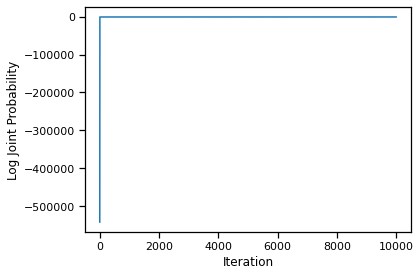

In [12]:
plt.plot(torch.arange(N_samples), samples["lps"])
plt.xlabel("Iteration")
plt.ylabel("Log Joint Probability")

plt.tight_layout()
# plt.savefig("lps1.pdf")

We see that the first few iterations are simply **burning in** the chain. We will discard these iterations in our subsequent analyses.

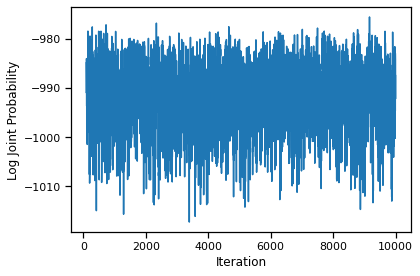

In [13]:
burnin = 100

plt.plot(torch.arange(burnin, N_samples), samples["lps"][burnin:])
plt.xlabel("Iteration")
plt.ylabel("Log Joint Probability")

plt.tight_layout()
# plt.savefig("lps2.pdf")

The trace from iteration 100 onward looks much more stable.

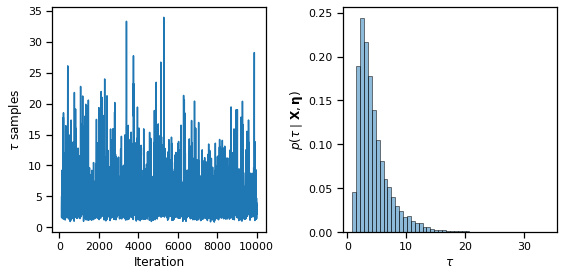

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(torch.arange(burnin, N_samples), 
            torch.sqrt(samples["tausq"][burnin:]))
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel(r"$\tau$ samples")

axs[1].hist(torch.sqrt(samples["tausq"][burnin:]), 50, 
            alpha=0.5, ec='k', density=True)
axs[1].set_xlabel(r"$\tau$")
axs[1].set_ylabel(r"$p(\tau \mid \mathbf{X}, \mathbf{\eta})$")

plt.tight_layout()
# plt.savefig("tau_samples.pdf")

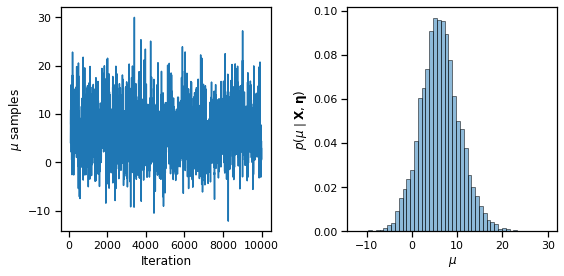

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(torch.arange(burnin, N_samples), samples["mu"][burnin:])
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel(r"$\mu$ samples")

axs[1].hist(samples["mu"][burnin:], 50, alpha=0.5, ec='k', density=True)
axs[1].set_xlabel(r"$\mu$")
axs[1].set_ylabel(r"$p(\mu \mid \mathbf{X}, \mathbf{\eta})$")

plt.tight_layout()
# plt.savefig("mu_samples.pdf")

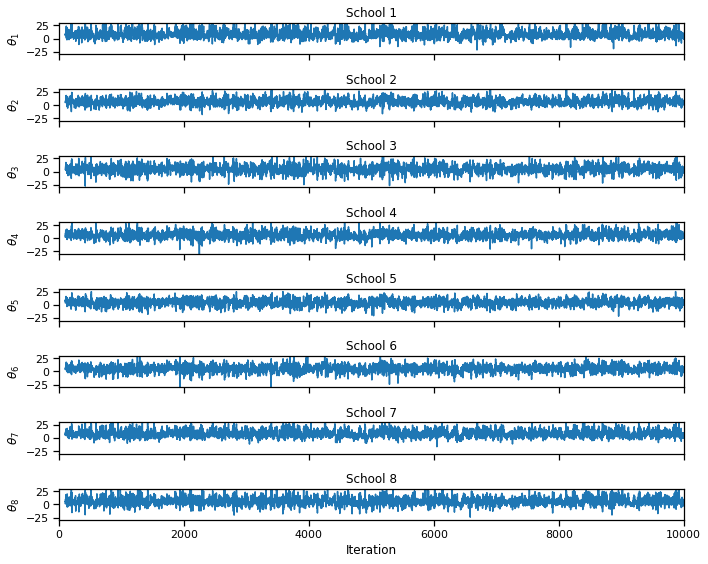

In [16]:
fig, axs = plt.subplots(S, 1, figsize=(10, 8), sharex=True)
for s in range(S):
    axs[s].plot(torch.arange(burnin, N_samples), samples["thetas"][burnin:, s])
    
    if s == S-1: axs[s].set_xlabel("Iteration")
    axs[s].set_ylabel(r"$\theta_{}$".format(s+1))
    axs[s].set_title("School {}".format(s+1))
    axs[s].set_xlim(0, N_samples)
    axs[s].set_ylim(-30, 30)

plt.tight_layout()
# plt.savefig("theta_samples1.pdf")

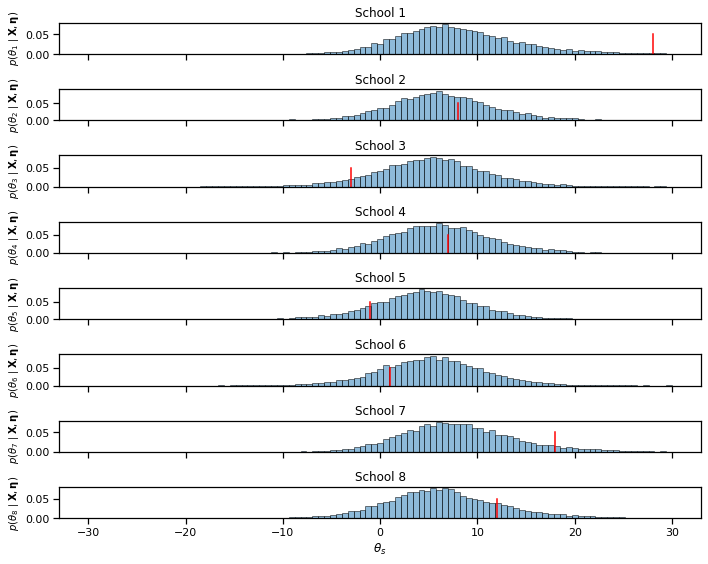

In [17]:
bins = torch.linspace(-30, 30, 100)
fig, axs = plt.subplots(S, 1, figsize=(10, 8), sharex=True)
for s in range(S):
    axs[s].hist(samples["thetas"][:, s], bins, edgecolor='k', 
                alpha=0.5, density=True)
    # axs[s].plot([x_bars[s], x_bars[s]], [0, 0.05], '-r')
    axs[s].plot(torch.mean(xs[:, s]) * torch.ones(2), [0, 0.05], '-r')
    
    if s == S-1: axs[s].set_xlabel(r"$\theta_s$")
    axs[s].set_ylabel(r"$p(\theta_" + str(s+1) \
                      + r" \mid \mathbf{X}, \mathbf{\eta})$",
                      fontsize=10)
    axs[s].set_title("School {}".format(s+1))

plt.tight_layout()
# plt.savefig("theta_samples2.pdf")

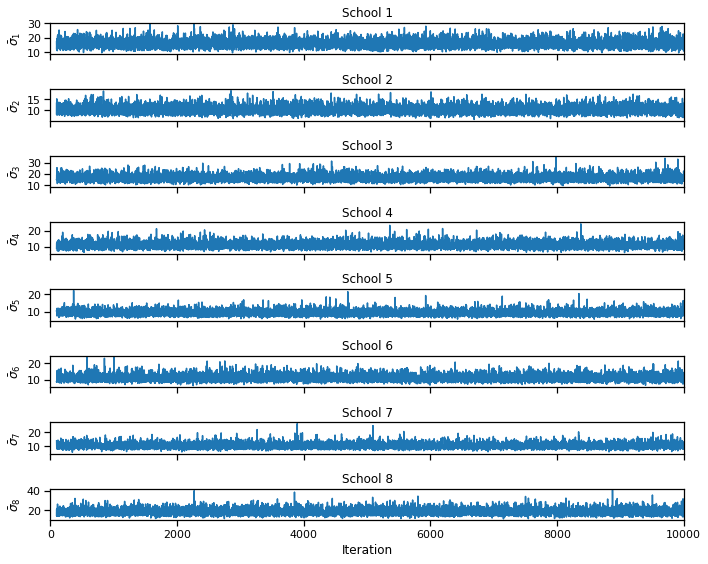

In [18]:
fig, axs = plt.subplots(S, 1, figsize=(10, 8), sharex=True)
for s in range(S):
    axs[s].plot(torch.arange(burnin, N_samples), 
                torch.sqrt(samples["sigmasqs"] / N_s)[burnin:, s])
    
    if s == S-1: axs[s].set_xlabel("Iteration")
    axs[s].set_ylabel(r"$\bar{{\sigma}}_{}$".format(s+1))
    axs[s].set_title("School {}".format(s+1))
    axs[s].set_xlim(0, N_samples)
    # axs[s].set_ylim(-30, 30)

plt.tight_layout()
# plt.savefig("sigma_samples1.pdf")

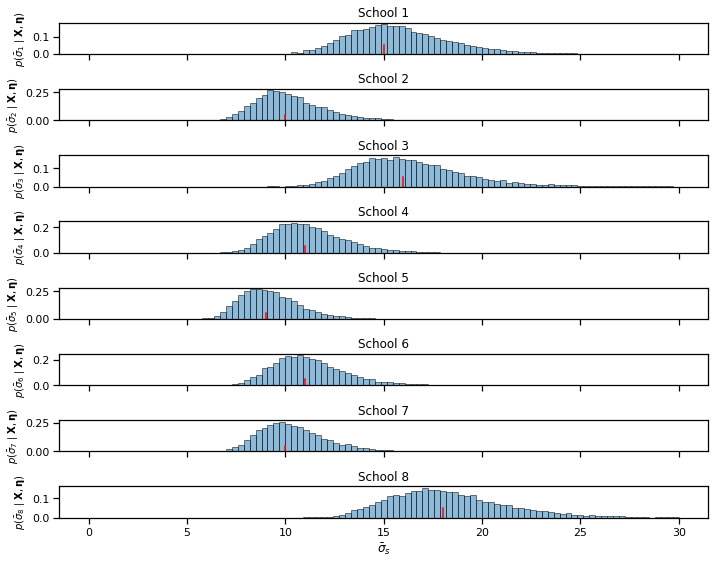

In [19]:
bins = torch.linspace(0, 30, 100)
fig, axs = plt.subplots(S, 1, figsize=(10, 8), sharex=True)
for s in range(S):
    axs[s].hist(torch.sqrt(samples["sigmasqs"] / N_s)[:, s], bins, 
                edgecolor='k', alpha=0.5, density=True)
    # axs[s].plot([x_bars[s], x_bars[s]], [0, 0.05], '-r')
    axs[s].plot(sigma_bars[s] * torch.ones(2), [0, 0.05], '-r')
    
    if s == S-1: axs[s].set_xlabel(r"$\bar{\sigma}_s$")
    axs[s].set_ylabel(r"$p(\bar{\sigma}_" + str(s+1) + \
                      r" \mid \mathbf{X}, \mathbf{\eta})$",
                      fontsize=10)
    axs[s].set_title("School {}".format(s+1))

plt.tight_layout()
# plt.savefig("sigma_samples2.pdf")

## MCMC Diagnostics

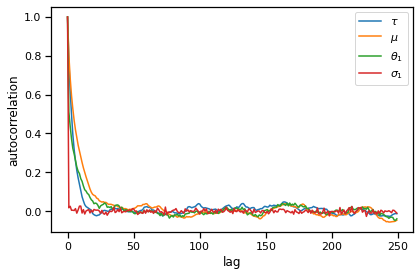

In [20]:
acf_tausq = autocorrelation(torch.sqrt(samples["tausq"][burnin:]))
acf_mu = autocorrelation(samples["mu"][burnin:])
acf_theta1 = autocorrelation(samples["thetas"][burnin:, 0])
acf_sigma1 = autocorrelation(torch.sqrt(samples["sigmasqs"])[burnin:, 0])

plt.plot(acf_tausq[:250], label=r"$\tau$")
plt.plot(acf_mu[:250], label=r"$\mu$")
plt.plot(acf_theta1[:250], label=r"$\theta_1$")
plt.plot(acf_sigma1[:250], label=r"$\sigma_1$")
plt.legend()
plt.xlabel("lag")
plt.ylabel("autocorrelation")

plt.tight_layout()
# plt.savefig("acf.pdf")

In [21]:
print("Effective sample sizes:")
print("tausq:    ", effective_sample_size(samples["tausq"][None, burnin:]))
print("mu:       ", effective_sample_size(samples["mu"][None, burnin:]))
print("theta1:   ", effective_sample_size(samples["thetas"][None, burnin:, 0]))
print("sigamsq1: ", effective_sample_size(samples["sigmasqs"][None, burnin:, 0]))

Effective sample sizes:
tausq:     tensor(1563.3730)
mu:        tensor(625.2454)
theta1:    tensor(1027.9814)
sigamsq1:  tensor(8996.0498)


## Recap

This notebook implemented a Gibbs sampler for the hierarchical Gaussian model from Lecture 3. We showed:
- How to derive the **complte conditional** distributions for each variable and sample from them.
- A **blocked Gibbs update** for the per-school means and variances, since those parameters are conditionally independent given the rest.
- Monitoring the algorithm's performance by plotting the log joint probability over iterations.
- Visualizing of the **posterior marginal probabilities** for each variable by simply taking a histogram of samples (after discarding a few burnin samples).
- MCMC diagnostics like the **autocorrelation function** and the **effective sample size.**
